The functions inside the `python_scripts/data` module are designed to download and manipulate datasets. Here is a brief description of each function:

1. `download_dataset(url, filename, folder)`: This function takes in the URL of a dataset, the desired filename for the downloaded file, and the folder name for the extracted dataset. It downloads the dataset from the specified *URL*, saves it with the given *filename*, and extracts it to the specified *folder*.

2. `make_data(folder)`: This function generates a dataframe by reading and processing the .DAT files inside the specified folder. It returns the dataframe containing the dataset. If the `dataset.pkl` file has already been generated, it just reads and save its content.

3. `plot_data(data, index)`: This function takes in a dataframe `data` and an index value. It plots the light curve for the SN associated to the specified index in the dataset.

In [15]:
# Import all useful functions to download and manipulate the dataset
from python_scripts.data import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# URL of the dataset
url = 'https://www.hep.anl.gov/SNchallenge/DES_BLIND+HOSTZ.tar.gz'
# Name of the downloaded file
filename = 'dataset.tar.gz'
# Name of the extracted folder
folder = 'DES_BLIND+HOSTZ'

There is no need to execute the `download_dataset()` function if the `dataset.pkl` file has already been generated, so if you do not wish to look at the original data simply do not execute (comment) the cell below.

In [16]:
# Download and extract the dataset 
download_dataset(url, filename, folder)

Dataset already downloaded.
Dataset already extracted.


In [17]:
# Generate the dataframe for all the .DAT files inside the DES_BLIND folder
data = make_data(folder)

Dataset already generated.


#### *__Dataset__*
Unfortunately, we only have $1250$ labelled supernova events available, compared to over $17000$ data for which the type of event is not provided. The aim is to combine the application of supervised learning and unsupervised learning techniques to obtain a classifier with satisfactory accuracy.

In [18]:
# Count the number of data points with SNTYPE == '-9' and all the other possibilities
label_counts = data['SNTYPE'].value_counts()
label_table = pd.DataFrame({'Label': label_counts.index, 'Count': label_counts.values})
label_table['Percentage'] = (label_table['Count'] / label_table['Count'].sum() * 100).round(2)
label_table['SN Type'] = ['Unknown', 'Type Ia', 'Type IIn', 'Type IIp', 'Type IIL', 'Type Ibc', 'Type Ib', 'Type Ic']
label_table


,Label,Count,Percentage,SN Type
0,-9,17052,93.17,Unknown
1,1,879,4.80,Type Ia
2,22,216,1.18,Type IIn
3,32,55,0.30,Type IIp
4,21,44,0.24,Type IIL
5,33,42,0.23,Type Ibc
6,3,12,0.07,Type Ib
7,23,2,0.01,Type Ic


By looking at the `make_data()` function, I'd like to highlight two aspects regarding the final adjustments to the dataframe:

1. For now, we simply clean the dataset by removing `nan` values. Replacing these values using some common strategies (*fixed*, *average* or *fitted* values) could be a source of error, as each SNS is identified precisely by the feature set.

2. As you can see from the original `.DAT` files, the observation time is given in Modified Julian Days (MJD). Although the unit of measurement is not a problem from the perspective of the classification algorithm, it is good to convert these values into **number of days since first observation** to visualise the light curves.

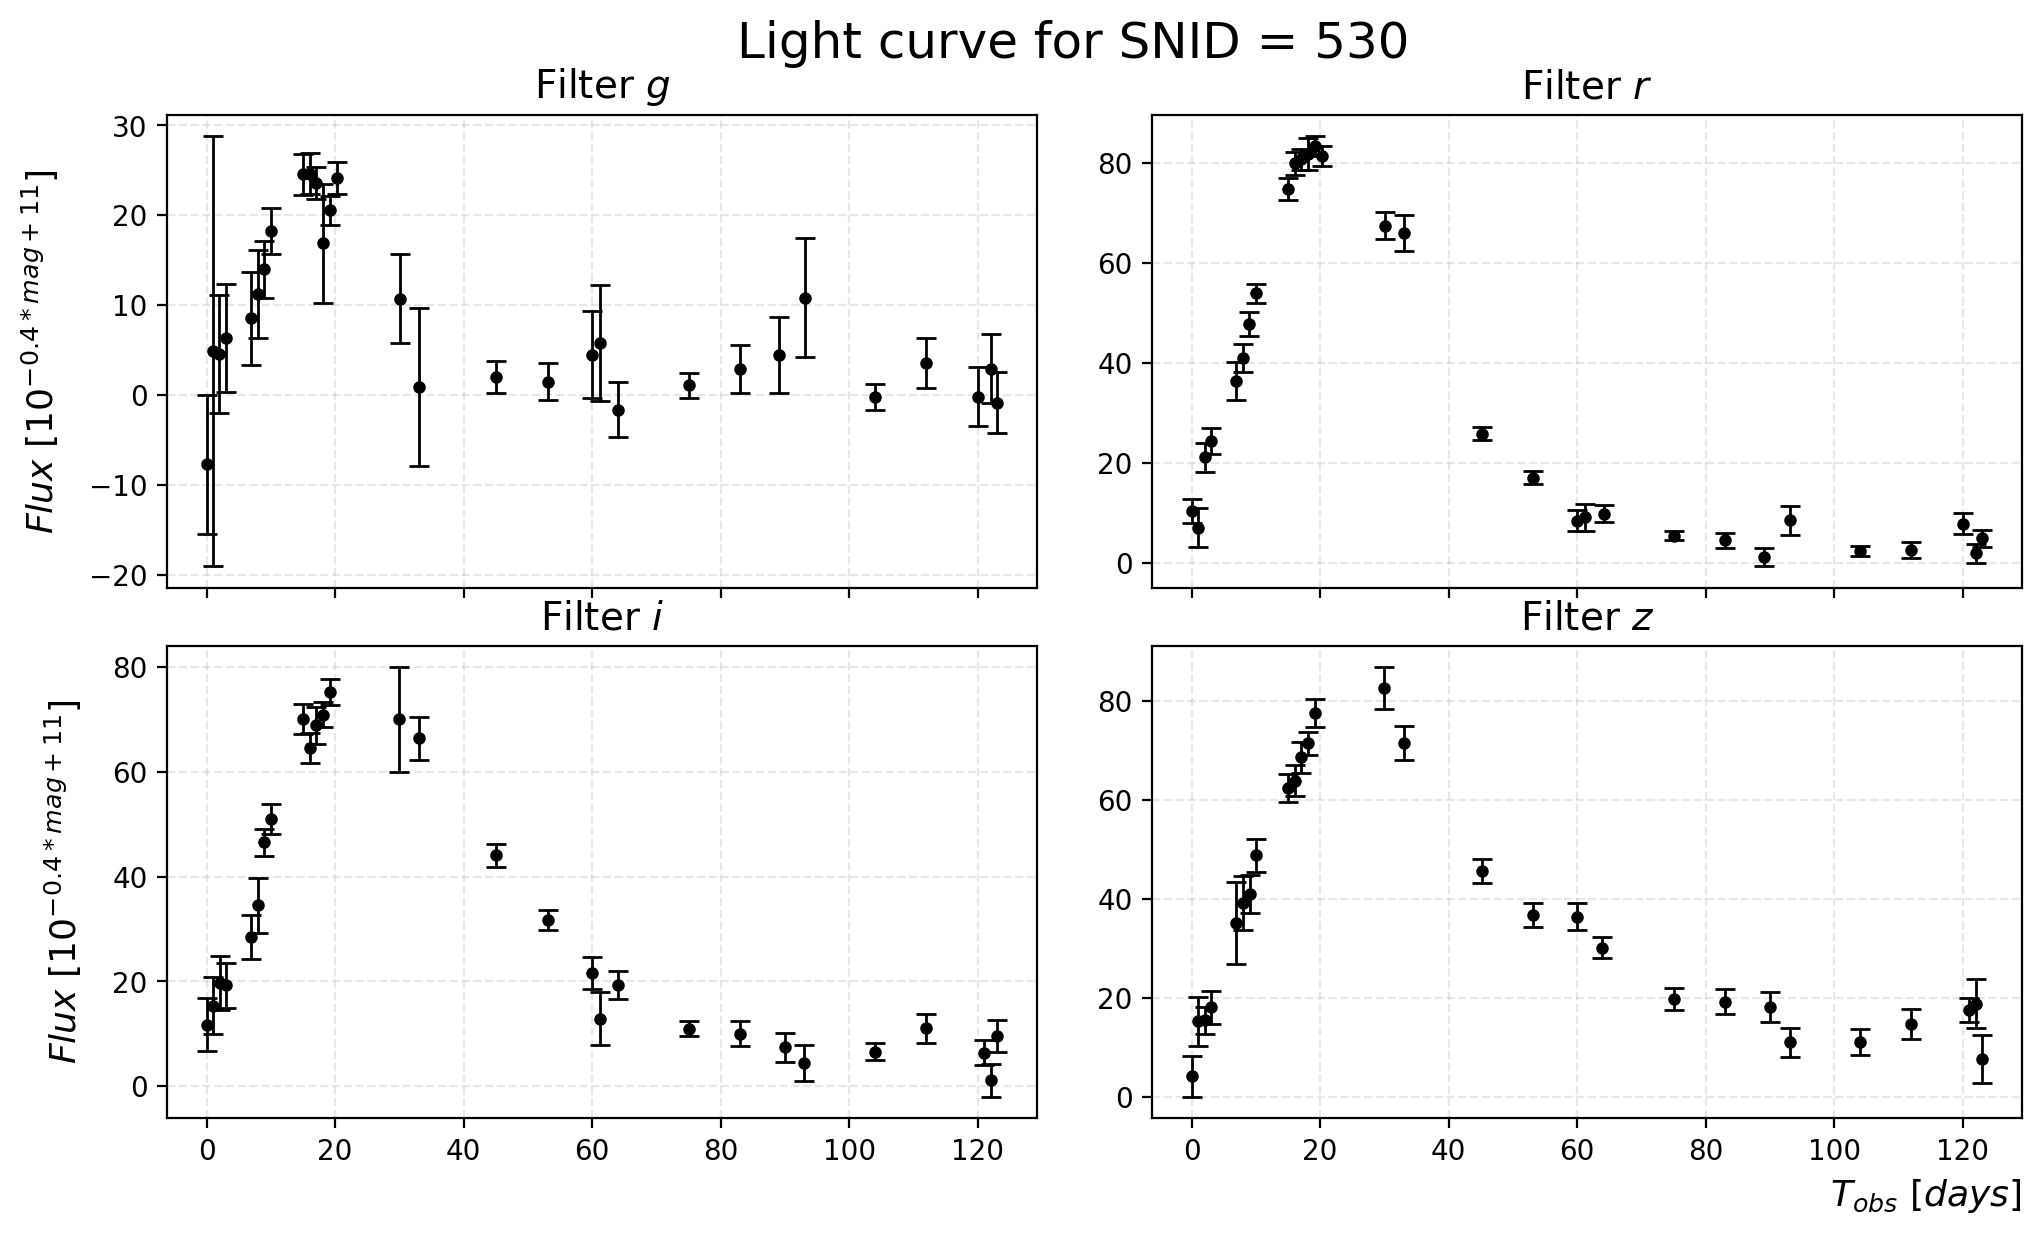

In [29]:
# Plot the SN530 Light Curve
plot_data(data, SNID=530)

In [20]:
# Define the training data as the data points with known SNTYPE
train_data = data[data['SNTYPE'] != '-9']

Note that this training set is not representative in brightness, therefore in *redshift* ($z$). This was done to emulate the way spectroscopic measures are currently performed, prioritizing low-redshift, bright objects.

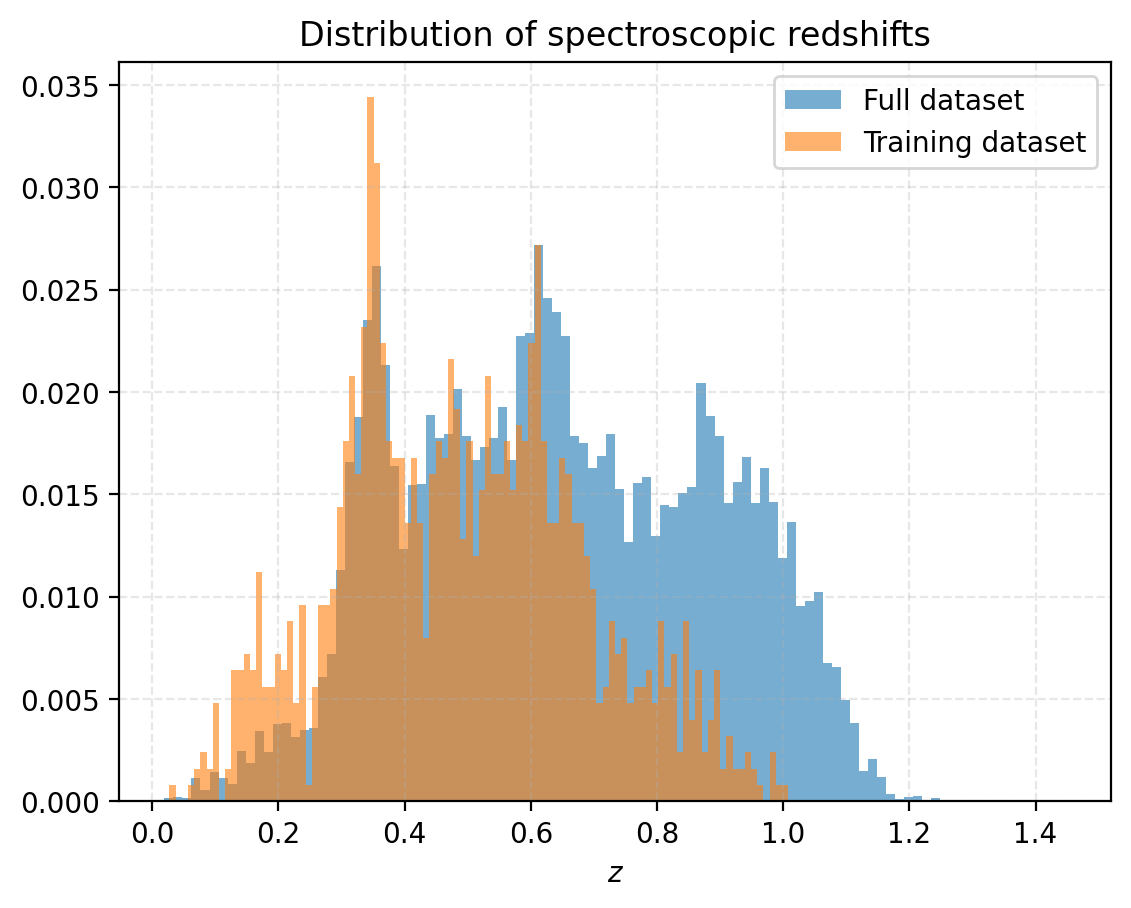

In [21]:
# Look at the distribution of the spectroscopic redshifts for both the full dataset and the training dataset
for df, label in zip([data['HOST_GALAXY_PHOTO-Z'], train_data['HOST_GALAXY_PHOTO-Z']], ['Full dataset', 'Training dataset']):
    plt.hist(df, bins=100, alpha=0.6, label=label,
            weights=np.zeros_like(df) + 1. / df.size);
plt.legend()
plt.grid(True, alpha=0.3, linestyle='--')
plt.title('Distribution of spectroscopic redshifts')
plt.xlabel('$z$')
plt.show()

In [22]:
# Instantiate the class to get the parameters of the training data
inst = getParams(train_data)
# Fit the data to get the light curve parameters
train_data = inst.fitData()

Fitting light curves: 100%|████████████████████| 1250/1250 [24:56<00:00,  1.20s/it] 

Dataset generated.


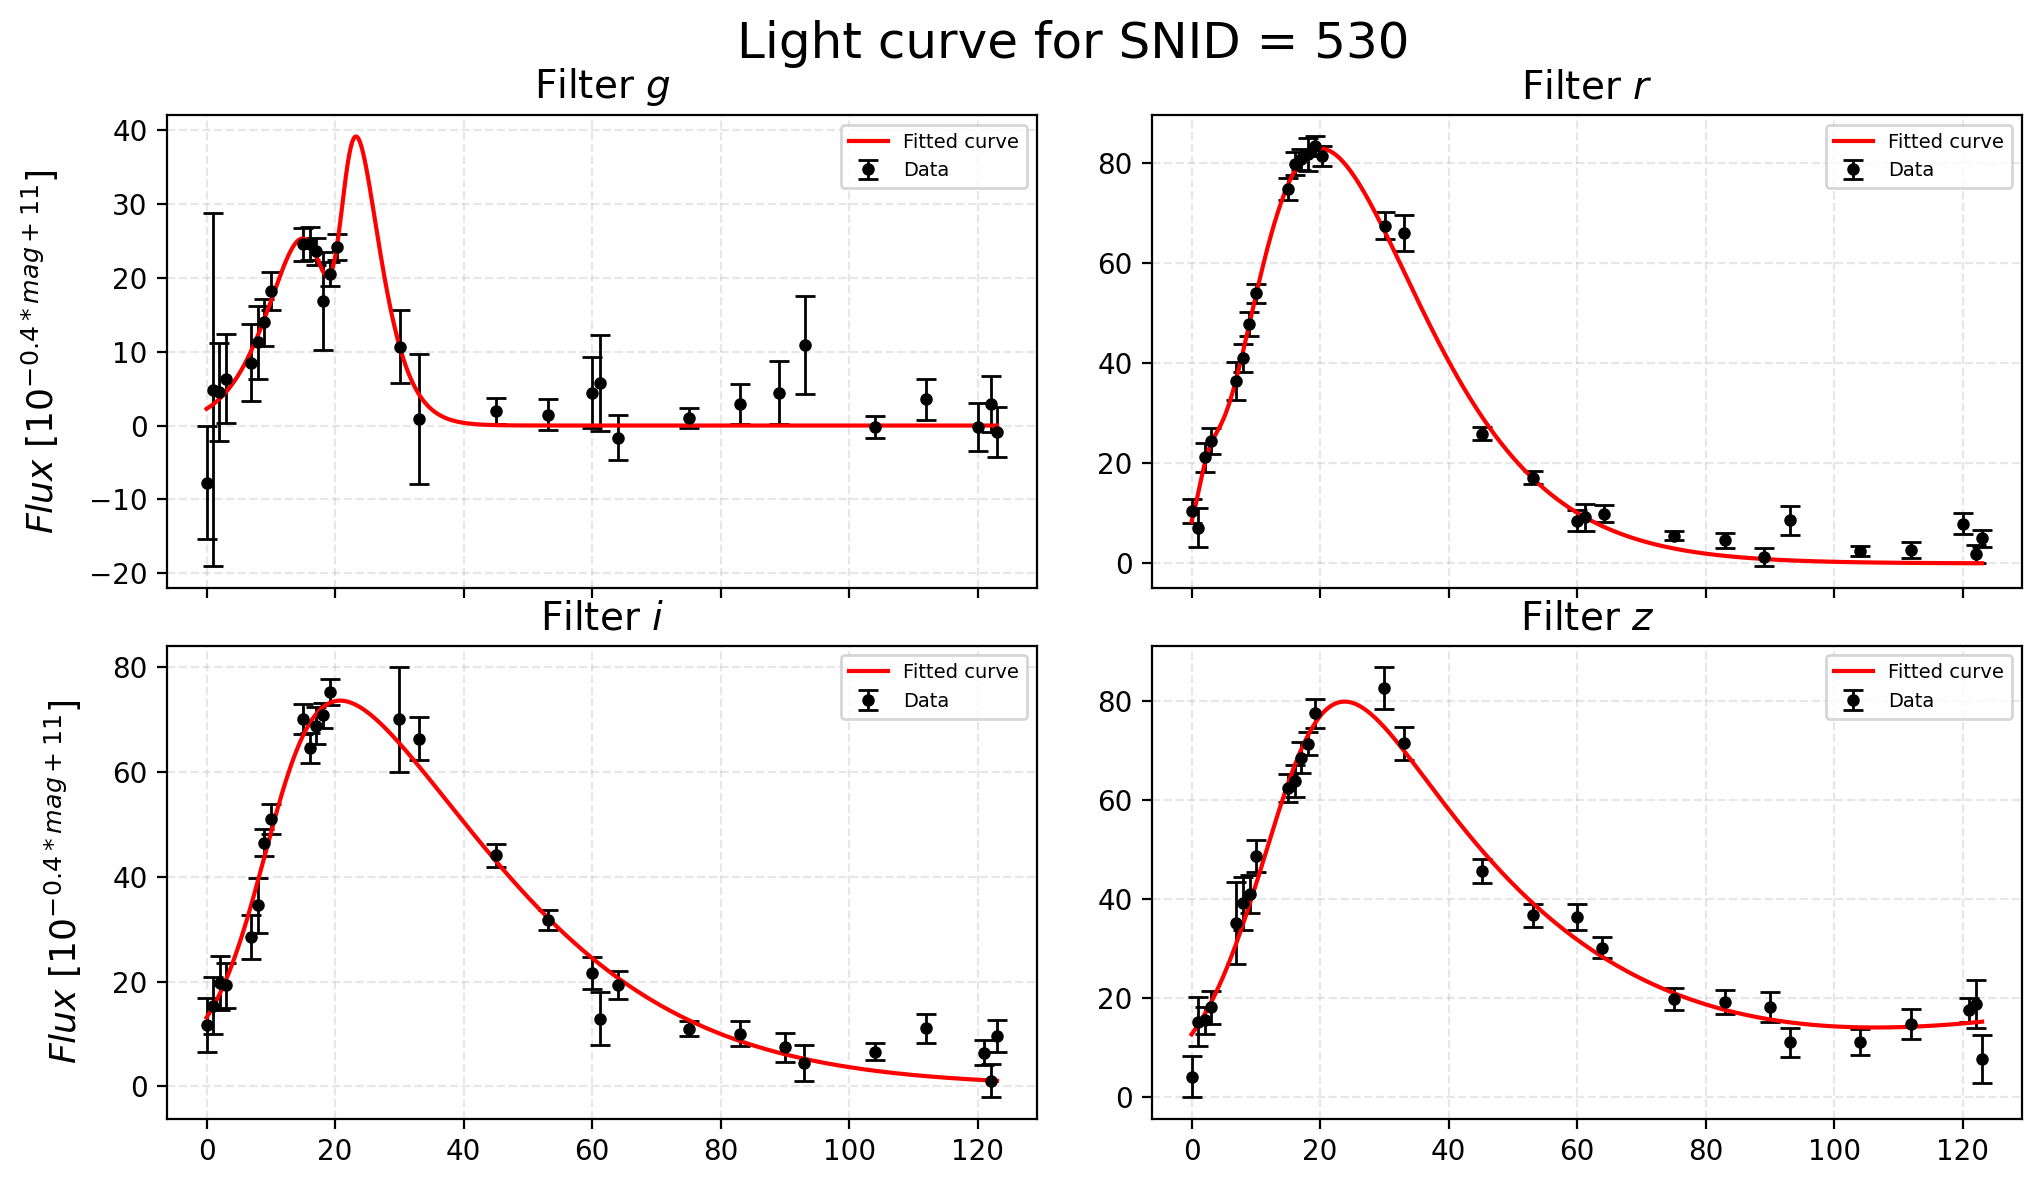

In [28]:
# As you can see, the model takel into account double peaks
plot_light_curves(train_data, inst.par_cols, SNID=train_data.iloc[3]['SNID'])